**OCT image segmentation**

*   Optimizer - AdaBound
*   Loss - sparse categorical crossentropy
*   image resolution 512x256, 
*   Batch size = 4
*   6 fold cross validation

---
**Models**
1.   vanilla U-net
2.   Att U-net

---
**Data augmentation**

*   horizontal flip
*   rotate (angle in range (-8, 8))



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### importing packages
import os
import glob

import numpy as np

import pandas as pd

import cv2

import PIL
from PIL import Image
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import *
from keras.models import *
from keras import regularizers, optimizers
from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import *
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from skimage.transform import resize
from scipy.ndimage.interpolation import rotate
from scipy import ndimage, misc

from IPython.display import Image, display

import random
seed = 42
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(tf.__version__)

2.9.2


In [50]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
img_size = (IMG_HEIGHT, IMG_WIDTH)
num_classes = 8 #8 in case just fluids is 4, in case fluids and layers is 8
batch_size = 4 # try 4, 8, 12, 16, 32


# paths to image folders 
train_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/6FCV/3case/train/raw'
train_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/6FCV/3case/train/mask/'


### FOR TESTING
val_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/10F/test/raw'
val_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/10F/test/mask'




**Prepare paths of input images and target segmentation masks**

In [51]:
input_img_paths = sorted(
    [
        os.path.join(train_img_path, fname)
        for fname in os.listdir(train_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(train_mask_path, fname)
        for fname in os.listdir(train_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of training samples:", len(input_img_paths))

Number of training samples: 936


**Displaying images and masks - check**


In [6]:
# colour definition
black = np.array([0, 0, 0, 255])
white = np.array([255, 255, 255, 255])
yellow = np.array([255, 255, 0, 255])
red = np.array([255, 0, 0, 255]) 
blue = np.array([0, 0, 255, 255])
light_blue = np.array([0, 255, 255, 255])
green = np.array([0, 255, 0, 255])
pink = np.array([255, 0, 255, 255]) 

# function which trasform mask values 0,1,2,3,4,5,6,7 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 4))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==0):
                col_mask[i,j]=black
            elif (mask[i,j]==1):
                col_mask[i,j]= red
            elif (mask[i,j]==2):
                col_mask[i,j]= yellow
            elif (mask[i,j]==3):
                col_mask[i,j]= white
            elif (mask[i,j]==4):
                col_mask[i,j]= blue
            elif (mask[i,j]==5):
                col_mask[i,j]=light_blue
            elif (mask[i,j]==6):
                col_mask[i,j]=pink
            elif (mask[i,j]==7):
                col_mask[i,j]=green
           
    return col_mask

Image id: 13 patient15_raw0030.png



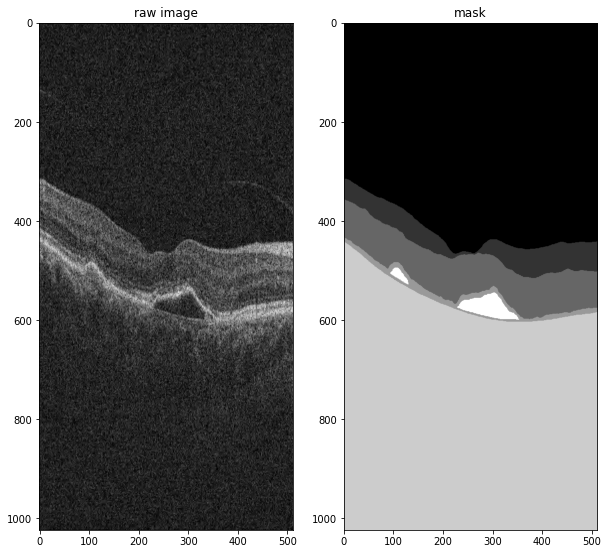

(array([644916,      0,  65280,      0, 121824,      0,  19641,      0,
       708801,  12402]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))


In [7]:
m=os.listdir(train_img_path)
#i = np.random.randint(0,len(m))
i = 13
print('Image id:', i ,  m[i])
print()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('raw image')
#raw = load_img(input_train_paths[i])
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))

plt.imshow(raw)

plt.subplot(1, 2, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)

plt.show()

print(np.histogram(mask))

In [8]:
class OCT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    seed = 42
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        flp = np.zeros((batch_size,) + self.img_size + (1,))
        angle = np.zeros((batch_size,) + self.img_size + (1,))
        
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            seed = 13
            np.random.seed = 13
            #flipping
            flp [j] = np.random.randint(0,3)
            flp = np.append (flp, flp[j])
            if flp [j] ==1:
              img = np.fliplr(img)
            #rotating
            angle[j] = np.random.randint(-8, 8)
            angle = np.append(angle, angle[j])
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            if flp [j] ==1:
              img = np.fliplr(img)
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            y[j] = img
        return x, y



In [9]:
class OCT_test(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y

        

In [10]:
import random

# Split our train paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OCT_test(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OCT_test(batch_size, img_size, val_input_img_paths, val_target_img_paths)

**MODELS**

**standard U-net**
*   with BN




In [11]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (1,))

    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation("relu")(conv5)

    x6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.add([x6, conv4])
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation("relu")(conv6)

    x7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),padding='same')(conv6)
    up7 = layers.add([x7, conv3])
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation("relu")(conv7)

    x8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.add([x8, conv2])
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation("relu")(conv8)

    x9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.add([x9, conv1])
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation("relu")(conv9)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)
    
    # Define the model
    model = keras.Model(inputs, outputs)
   
       
    return model

    


# Build model
model = get_model(img_size, num_classes)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

 **Attention U-net**

In [11]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [12]:
def repeat_elem(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [13]:
def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [14]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [15]:
def get_model (img_size, num_classes, dropout_rate=0.0, batch_norm=True):
  
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    inputs = keras.Input(shape=img_size + (1,))
  
    # Downsampling layers
    
    conv_128 = conv_block(inputs, 3, 64, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
   
    conv_64 = conv_block(pool_64, 3, 128, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    
    conv_32 = conv_block(pool_32, 3, 256, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    
    conv_16 = conv_block(pool_16, 3, 512, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    
    conv_8 = conv_block(pool_8, 3, 1024, dropout_rate, batch_norm)

    # Upsampling layers
    
    gating_16 = gating_signal(conv_8, 512, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 512)
    up_16 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, 3, 512, dropout_rate, batch_norm)
    
    gating_32 = gating_signal(up_conv_16, 256, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 256)
    up_32 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, 3, 256, dropout_rate, batch_norm)
    
    gating_64 = gating_signal(up_conv_32, 128, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 128)
    up_64 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, 3, 128, dropout_rate, batch_norm)
    
    gating_128 = gating_signal(up_conv_64, 128, batch_norm)
    att_128 = attention_block(conv_128, gating_128, 128)
    up_128 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, 3, 128, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final) 

    # Model integration
    model = keras.Model(inputs, conv_final)
    return model

 
    
   

In [16]:
model = get_model(img_size, num_classes, dropout_rate=0.0, batch_norm=True)

In [ ]:
### prikaz modela
#tf.keras.utils.plot_model(model, show_shapes=True)

**TRAINING**


*   optmizer - AdaBound




In [17]:
pip install keras-adabound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6607 sha256=a983881e0fd7dd32311d13442905e7fbb3084abc6676d38601f3b8c536321a03
  Stored in directory: /root/.cache/pip/wheels/bc/8a/34/f7fd8b562417782e64c61fd17829dc5a153a46ec58065aa570
Successfully built keras-adabound


In [18]:
from keras_adabound import AdaBound
opt=AdaBound(learning_rate=1e-3, final_lr=0.1)

In [ ]:
#opt="rmsprop"
#opt=Adam(learning_rate=1e-5)
#opt=Adagrad
#opt = tf.keras.optimizers.SGD(learning_rate=0.1)

In [19]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy")
#model.compile(optimizer=opt, loss=tversky_loss)

In [20]:
callbacks = [
    #keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]
# Train the model, doing validation at the end of each epoch.
epochs = 150
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/150
184/184 [==============================] - 289s 1s/step - loss: 0.8086 - val_loss: 1.1509
Epoch 2/150
184/184 [==============================] - 180s 976ms/step - loss: 0.3765 - val_loss: 0.3211
Epoch 3/150
184/184 [==============================] - 179s 975ms/step - loss: 0.2080 - val_loss: 0.2062
Epoch 4/150
184/184 [==============================] - 179s 976ms/step - loss: 0.1447 - val_loss: 0.1299
Epoch 5/150
184/184 [==============================] - 179s 975ms/step - loss: 0.1126 - val_loss: 0.1118
Epoch 6/150
184/184 [==============================] - 180s 976ms/step - loss: 0.0948 - val_loss: 0.1465
Epoch 7/150
184/184 [==============================] - 179s 976ms/step - loss: 0.0831 - val_loss: 0.1947
Epoch 8/150
184/184 [==============================] - 180s 976ms/step - loss: 0.0760 - val_loss: 0.0751
Epoch 9/150
184/184 [==============================] - 179s 975ms/step - loss: 0.0677 - val_loss: 0.2493
Epoch 10/150
184/184 [==============================] - 17

In [ ]:
#model.save("my_model")

In [ ]:
#model = keras.models.load_model("my_model")

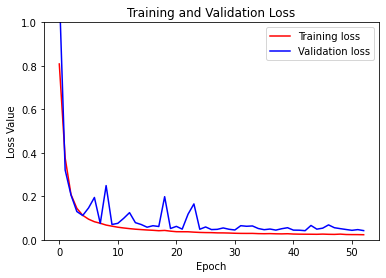

In [23]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(53)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Getting predictions**

In [52]:
input_img_paths = sorted(
    [
        os.path.join(val_img_path, fname)
        for fname in os.listdir(val_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(val_mask_path, fname)
        for fname in os.listdir(val_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of testing samples:", len(input_img_paths))

Number of testing samples: 87


In [53]:
test_gen = OCT_test(batch_size, img_size, input_img_paths, target_img_paths)
test_preds = model.predict(test_gen)

21/21 [==============================] - 40s 2s/step


In [54]:
print(np.shape(test_preds))

(84, 512, 256, 8)


**Visualazing predictions**

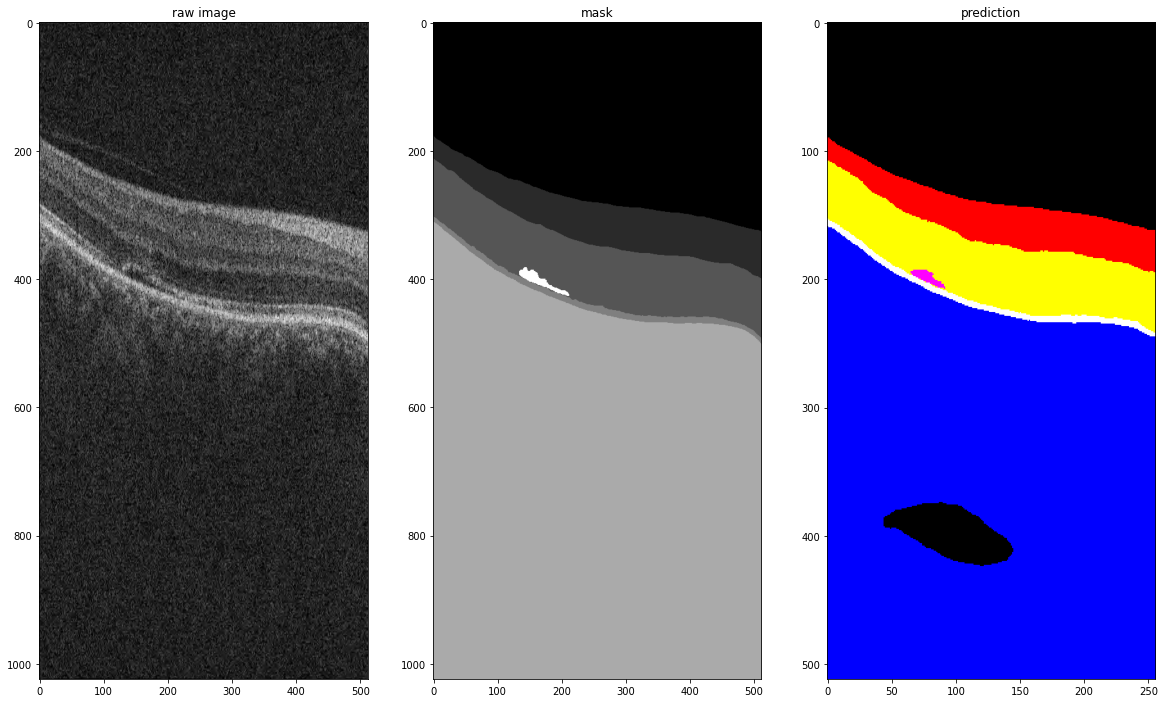

In [61]:
m=os.listdir(val_img_path)
#i = np.random.randint(0,len(input_img_paths)-1)
i=1
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.title('raw image')
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
plt.imshow(raw)

plt.subplot(1, 3, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('prediction')
pred = test_preds[i]
pred = np.argmax(pred, axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
plt.imshow(pred)



plt.show()


In [62]:
i = 1
print('Image id:', i ,  m[i])

Image id: 1 patient10_raw0039.png


**Confusion matrix**

In [63]:
i= 0

mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))

pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)

pred_vector=pred.flatten()
mask_vector=mask.flatten()


# i range from 1 to number of images in val (test) set
for i in range(1, 84):
  mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))    
  mask_vector = np.concatenate((mask_vector, mask.flatten()), axis=0)
  pred = np.argmax(test_preds[i], axis=-1)

 

  pred = np.expand_dims(pred, axis=-1)
  pred_vector = np.concatenate((pred_vector, pred.flatten()), axis=0)

1. sklearn

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(mask_vector, pred_vector)

In [65]:
print(cf_matrix)

[[3169668    1604       0       0       0       0       0       0]
 [  14476  534914   97499       0       0       0       0      54]
 [    863    1577  813631    4870      24     135   26729     993]
 [      0       0   10441   93331    5666    3933    3011       0]
 [  51510       0       0    9062 6030261    2715       0       0]
 [      0       0      61    3212    1247   26802    5314       0]
 [      0       0    7975    1423       6     481   53676      34]
 [  10050     809   13969       0       0       0      86    7936]]


In [66]:
cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]
print(cf_matrix_normal )

[[9.99494209e-01 5.05790736e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.23760053e-02 8.26833276e-01 1.50707249e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.34694865e-05]
 [1.01670315e-03 1.85786891e-03 9.58541367e-01 5.73736307e-03
  2.82744792e-05 1.59043946e-04 3.14895231e-02 1.16985658e-03]
 [0.00000000e+00 0.00000000e+00 8.97131859e-02 8.01936726e-01
  4.86845045e-02 3.37938857e-02 2.58716984e-02 0.00000000e+00]
 [8.45320329e-03 0.00000000e+00 0.00000000e+00 1.48714673e-03
  9.89614097e-01 4.45553231e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.66502893e-03 8.76733268e-02
  3.40375587e-02 7.31575500e-01 1.45048586e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.25402940e-01 2.23759730e-02
  9.43470399e-05 7.56348770e-03 8.44028619e-01 5.34633226e-04]
 [3.05936073e-01 2.46270928e-02 4.25235921e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.61796043e-03 2.41582953e-01]]

In [67]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

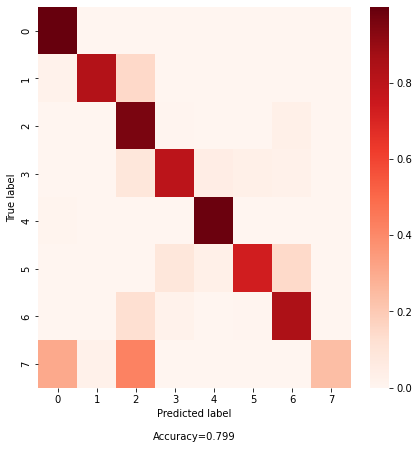

In [68]:
make_confusion_matrix(cf_matrix_normal, count = False, percent = False, figsize=(7,7), cbar=True, cmap='Reds')

In [69]:
#cf_matrix_normal = (cm1+cm2+cm3+cm4+cm5+cm6)/6

2. pycm

In [70]:
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import pycm
from pycm import *

In [72]:
cm = ConfusionMatrix(actual_vector=mask_vector, predict_vector=pred_vector)
cm.classes

[0, 1, 2, 3, 4, 5, 6, 7]

In [73]:
print(cm)

Predict       0             1             2             3             4             5             6             7             
Actual
0             3169668       1604          0             0             0             0             0             0             

1             14476         534914        97499         0             0             0             0             54            

2             863           1577          813631        4870          24            135           26729         993           

3             0             0             10441         93331         5666          3933          3011          0             

4             51510         0             0             9062          6030261       2715          0             0             

5             0             0             61            3212          1247          26802         5314          0             

6             0             0             7975          1423          6             481           